# Bayesian Optimisation Over Molecules using Input Warping #

An example notebook for Bayesian optimisation on a molecular dataset using a Tanimoto fingerprint kernel with input warping on the photoswitch dataset

Paper: https://pubs.rsc.org/en/content/articlelanding/2022/sc/d2sc04306h

Code: https://github.com/Ryan-Rhys/The-Photoswitch-Dataset

A key aspect of this Bayesian optimisation loop is that the queried molecules, $\mathbf{x^*}$. are drawn from a discrete set of heldout molecules, $\mathcal{D}_{\text{heldout}}$. Such situations may arise in virtual screening campaigns where one wishes to select a molecule for synthesis from a virtual library. In this case the acquisition function is evaluated on a discrete set and the maximum of the set is taken as the proposed candidate at each iteration of Bayesian optimisation.

## 1. Input Warping

Input warping is a means of correcting for nonstationarity in the objective function by warping (transforming) the input space and has been popular in a number of BO algorithms for **continuous** input space [1, 2]. In this instance the kernel becomes $K(w(\mathbf{x}), w(\mathbf{x}'))$, where $w$ represents a function that warps the inputs. The original warping function introduced in [2] was the Beta cumulative distribution function (cdf)

\begin{align}
w_d(x_d) = \text{BetaCDF}(x_d; \alpha_d, \beta_d) = \int_0^{x_d} \frac{u^{\alpha_d - 1} (1 - u)^{\beta_d - 1}}{B(\alpha_d, \beta_d)} du,
\end{align}

where $\text{BetaCDF}$ refers to the Beta cumulative distribution function. $w:[0, 1]^D \rightarrow [0, 1]^D$ is a vector-valued function such that the dth output dimension is a funciton of the dth input dimension yielding $D$ bijective transformations with shape determined by the nonnegative parameters $\alpha_d > 0$ and $\beta_d > 0$. The Beta cdf has no closed-form solution for non-integer values but accurate approximations exist in various software packages. Nonetheless, [3] introduced a differentiable and closed-form cdf known as the Kumaraswamy transformation,

\begin{align}
K_{\text{cdf}}(x) = 1 - (1 - x^a)^b,
\end{align}

where $a$ and $b$ are learnable concentration parameters and $K_{\text{cdf}}$ maps from [0, 1] to [0, 1]. We make use of the Kumaraswamy input warping function in HEBO. An illustration of the kind of stationarity-inducing warping afforded by the Beta cdf and Kumaraswamy transforms is given below.

<p align="centre">
  <img src="assets/input_warping.png" width="900" title="Input Warping">
</p>

Image courtesy of [2]. We will now implement the Kumaraswamy input transform in the BoTorch [3] framework. It should be noted that it is unclear what benefit should be expected for input warping over non-continuous molecular input spaces.

In [24]:
"""Imports."""

import time
import warnings
warnings.filterwarnings("ignore") # Turn off Graphein warnings

from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
import torch
from botorch import fit_gpytorch_model
from botorch.acquisition import ExpectedImprovement
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.models.gp_regression import SingleTaskGP
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean
from gpytorch.mlls import ExactMarginalLogLikelihood
from sklearn.model_selection import train_test_split

from gauche.dataloader import MolPropLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

We use the inverse cumulative distribution function (icdf) of the Kumaraswamy distribution as the generative process for our data. In this toy example, the application of the cumulative distribution function (cdf) when fitting the GP will *undo* the icdf transformation and allow the GP to be fit in a stationary setting.

Text(0, 0.5, 'Transformed Value')

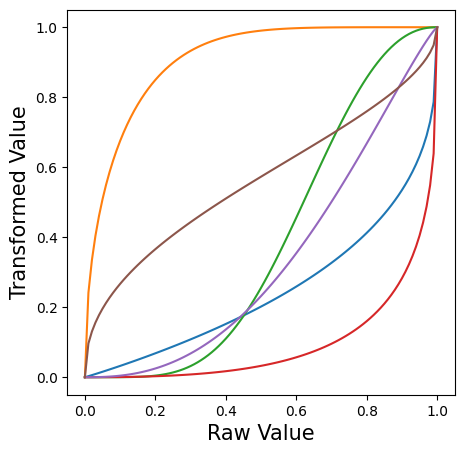

In [25]:
from torch.distributions import Kumaraswamy
import matplotlib.pyplot as plt

%matplotlib inline 
fontdict = {"fontsize": 15}
torch.manual_seed(1234567890)

# Draw concentration parameters c1 and c0 from a uniform distribution on [0, 1] then multiply by 3 and add 0.1.
# Hint: use torch.rand https://pytorch.org/docs/stable/generated/torch.rand.html
c1 = torch.rand(6, dtype=dtype, device=device) * 3 + 0.1
c0 = torch.rand(6, dtype=dtype, device=device) * 3 + 0.1

# Generate 100 points on the x axis using torch.linspace
x = torch.linspace(0, 1, 101, dtype=dtype, device=device)

# Initialise the Kumaraswamy distribution object with concentration parameters c1 and c0
k = Kumaraswamy(concentration1=c1, concentration0=c0)

# Compute the icdf of the Kumaraswamy transformation on an expanded version of x of size [101, 6]. 
# Hint: use the unsqueeze and expand functions
k_icdfs = k.icdf(x.unsqueeze(1).expand(101, 6))

# We visualise the generative warpings.
fig, ax = plt.subplots(1,1, figsize=(5,5))
for i in range(6):
    ax.plot(x.cpu(), k_icdfs[:, i].cpu())

ax.set_xlabel("Raw Value", **fontdict)
ax.set_ylabel("Transformed Value", **fontdict)

We now define our model with input warping.

In [12]:
from gauche.kernels.fingerprint_kernels.tanimoto_kernel import TanimotoKernel

# We define our custom GP surrogate model using the Tanimoto kernel

class TanimotoGP(SingleTaskGP):

    def __init__(self, train_X, train_Y, input_transform):
        super().__init__(train_X, train_Y, likelihood=GaussianLikelihood(), input_transform=input_transform)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(base_kernel=TanimotoKernel())
        self.to(train_X)  # make sure we're on the right device/dtype

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

We define helper functions for the Bayesian optimisation loop. In particular the acquisition function optimisation procedure is framed so as to take the maximum over a discrete set of heldout molecules.

In [13]:
from botorch.models.transforms.input import Warp
from gpytorch.priors.torch_priors import LogNormalPrior
from botorch.utils.transforms import standardize

def initialize_model(train_x, train_obj, use_input_warping=True, state_dict=None):
    """
    Initialize model and loss function.

    Args:
        train_x: tensor of inputs
        train_obj: tensor of outputs
        state_dict: current state dict used to speed up fitting

    Returns: mll object, model object
    """

    if use_input_warping:
        # initialize input_warping transformation
        warp_tf = Warp(
            indices=list(range(train_x.shape[-1])),
            # use a prior with median at 1.
            # when a=1 and b=1, the Kumaraswamy CDF is the identity function
            concentration1_prior=LogNormalPrior(0.0, 0.75 ** 0.5),
            concentration0_prior=LogNormalPrior(0.0, 0.75 ** 0.5),
        )
    else:
        warp_tf = None

    # define model for objective
    model = TanimotoGP(train_x, train_obj, input_transform=warp_tf).to(train_x)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    # load state dict if it is passed
    if state_dict is not None:
        model.load_state_dict(state_dict)

    return mll, model

def optimize_acqf_and_get_observation(acq_func, heldout_inputs, heldout_outputs):
    """
    Optimizes the acquisition function, and returns a new candidate and an observation.

    Args:
        acq_func: Object representing the acquisition function
        heldout_points: Tensor of heldout points

    Returns: new_x, new_obj
    """

    # Loop over the discrete set of points to evaluate the acquisition function at.
    acq_vals = []
    for i in range(len(heldout_outputs)):
        acq_vals.append(acq_func(heldout_inputs[i].unsqueeze(-2)))  # use unsqueeze to append batch dimension

    # observe new values
    acq_vals = torch.tensor(acq_vals)
    best_idx = torch.argmax(acq_vals)
    new_x = heldout_inputs[best_idx].unsqueeze(-2)  # add batch dimension
    new_obj = heldout_outputs[best_idx].unsqueeze(-1)  # add output dimension

    # Delete the selected input and value from the heldout set.
    heldout_inputs = torch.cat((heldout_inputs[:best_idx], heldout_inputs[best_idx+1:]), axis=0)
    heldout_outputs = torch.cat((heldout_outputs[:best_idx], heldout_outputs[best_idx+1:]), axis=0)

    return new_x, new_obj, heldout_inputs, heldout_outputs


def update_random_observations(best_random, heldout_inputs, heldout_outputs):
    """
    Simulates a random policy by taking a the current list of best values observed randomly,
    drawing a new random point from the heldout set, observing its value, and updating the list.

    Args:
        best_random: List of best random values observed so far
        heldout_inputs: Tensor of inputs
        heldout_outputs: Tensor of output values

    Returns: best_random, float specifying the objective function value.
    """

    # Take a random sample by permuting the indices and selecting the first element.
    index = torch.randperm(len(heldout_outputs))[0]
    next_random_best = heldout_outputs[index]
    best_random.append(max(best_random[-1], next_random_best))

    # Delete the selected input and value from the heldout set.
    heldout_inputs = torch.cat((heldout_inputs[:index], heldout_inputs[index+1:]), axis=0)
    heldout_outputs = torch.cat((heldout_outputs[:index], heldout_outputs[index+1:]), axis=0)

    return best_random, heldout_inputs, heldout_outputs

Run the Bayesian optimisation loop, comparing the analytic (sequential) expected improvement acquisition funciton with a random policy.

Found 13 invalid labels [nan nan nan nan nan nan nan nan nan nan nan nan nan] at indices [41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 158]
To turn validation off, use dataloader.read_csv(..., validate=False).

Trial  1 of 20 ....................
Trial  2 of 20 ....................
Trial  3 of 20 ....................
Trial  4 of 20 ....................
Trial  5 of 20 ....................
Trial  6 of 20 ....................
Trial  7 of 20 ....................
Trial  8 of 20 ....................
Trial  9 of 20 ....................
Trial 10 of 20 ....................
Trial 11 of 20 ....................
Trial 12 of 20 ....................
Trial 13 of 20 ....................
Trial 14 of 20 ....................
Trial 15 of 20 ....................
Trial 16 of 20 ....................
Trial 17 of 20 ....................
Trial 18 of 20 ....................
Trial 19 of 20 ....................
Trial 20 of 20 ....................

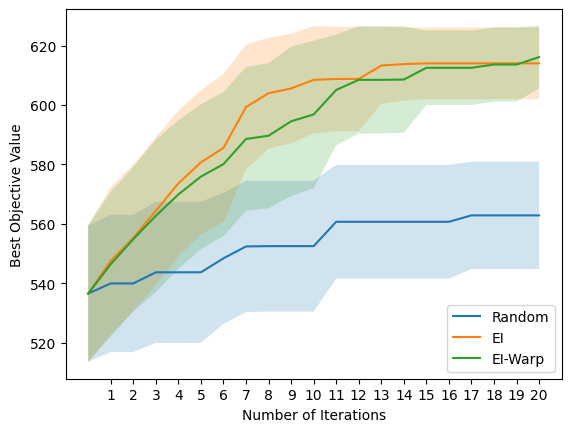

In [17]:
# Bayesian optimisation experiment parameters, number of random trials, split size, batch size
# and number of iterations of Bayesian optimisation.

N_TRIALS = 20
holdout_set_size = 0.95
N_ITERS = 20
verbose = False

# Load the Photoswitch dataset
loader = MolPropLoader()
loader.load_benchmark("Photoswitch")

# We use the fragprints representations (a concatenation of Morgan fingerprints and RDKit fragment features)
loader.featurize('ecfp_fragprints')
X = loader.features
y = loader.labels

warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

best_observed_all_warp, best_observed_all_ei, best_random_all = [], [], []

# average over multiple random trials (each trial splits the initial training set for the GP in a random manner)
for trial in range(1, N_TRIALS + 1):

    print(f"\nTrial {trial:>2} of {N_TRIALS} ", end="")
    best_observed_warp, best_observed_ei, best_random = [], [], []

    # Generate initial training data and initialize model
    train_x_ei, heldout_x_ei, train_y_ei, heldout_y_ei = train_test_split(X, y, test_size=holdout_set_size, random_state=trial)
    best_observed_value_ei = torch.tensor(np.max(train_y_ei))
    best_observed_value_warp = best_observed_value_ei

    # Convert numpy arrays to PyTorch tensors and flatten the label vectors
    train_x_ei = torch.tensor(train_x_ei.astype(np.float64))
    heldout_x_ei = torch.tensor(heldout_x_ei.astype(np.float64))
    train_y_ei = torch.tensor(train_y_ei)
    heldout_y_ei = torch.tensor(heldout_y_ei)
    train_x_warp, heldout_x_warp, train_y_warp, heldout_y_warp = train_x_ei, heldout_x_ei, train_y_ei, heldout_y_ei 

    # The initial heldout set is the same for random search
    heldout_x_random = heldout_x_ei
    heldout_y_random = heldout_y_ei

    mll_ei, model_ei = initialize_model(train_x_ei, train_y_ei, use_input_warping=False)
    mll_warp, model_warp = initialize_model(train_x_warp, train_y_warp, use_input_warping=True)

    best_observed_ei.append(best_observed_value_ei)
    best_observed_warp.append(best_observed_value_warp)
    best_random.append(best_observed_value_ei)

    # run N_ITERS rounds of BayesOpt after the initial random batch
    for iteration in range(1, N_ITERS + 1):

        t0 = time.time()

        # fit the model
        fit_gpytorch_model(mll_ei)
        fit_gpytorch_model(mll_warp)

        # Use analytic acquisition function for batch size of 1.
        EI = ExpectedImprovement(model=model_ei, best_f=(train_y_ei.to(train_y_ei)).max())
        EI_warp = ExpectedImprovement(model=model_warp, best_f=(train_y_warp.to(train_y_warp)).max())

        new_x_ei, new_obj_ei, heldout_x_ei, heldout_y_ei = optimize_acqf_and_get_observation(EI,
                                                                                             heldout_x_ei,
                                                                                             heldout_y_ei)
        new_x_warp, new_obj_warp, heldout_x_warp, heldout_y_warp = optimize_acqf_and_get_observation(EI_warp,
                                                                                             heldout_x_warp,
                                                                                             heldout_y_warp)

        # update training points
        train_x_ei = torch.cat([train_x_ei, new_x_ei])
        train_y_ei = torch.cat([train_y_ei, new_obj_ei])
        train_x_warp = torch.cat([train_x_warp, new_x_warp])
        train_y_warp = torch.cat([train_y_warp, new_obj_warp])

        # update random search progress
        best_random, heldout_x_random, heldout_y_random = update_random_observations(best_random,
                                                                                     heldout_inputs=heldout_x_random,
                                                                                     heldout_outputs=heldout_y_random)
        best_value_ei = torch.max(new_obj_ei, best_observed_ei[-1])
        best_observed_ei.append(best_value_ei.squeeze())
        best_value_warp = torch.max(new_obj_warp, best_observed_warp[-1])
        best_observed_warp.append(best_value_warp.squeeze())

        # reinitialise the model so it is ready for fitting on the next iteration
        # use the current state dict to speed up fitting
        mll_ei, model_ei = initialize_model(
            train_x_ei,
            train_y_ei,
            use_input_warping=False,
            state_dict=model_ei.state_dict(),
        )
        mll_warp, model_warp = initialize_model(
            train_x_warp,
            train_y_warp,
            use_input_warping=True,
            state_dict=model_warp.state_dict(),
        )

        t1 = time.time()

        if verbose:
            print(
                f"\nBatch {iteration:>2}: best_value (random, qEI, qEI-Warp) = "
                f"({max(best_random):>4.2f}, {best_value_ei:>4.2f}), {best_value_warp:>4.2f}),"
                f"time = {t1 - t0:>4.2f}.", end=""
            )
        else:
            print(".", end="")

    best_observed_all_ei.append(torch.hstack(best_observed_ei))
    best_observed_all_warp.append(torch.hstack(best_observed_warp))
    best_random_all.append(torch.hstack(best_random))

# Define a confience interval function for plotting.
def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)

iters = np.arange(N_ITERS + 1)
y_ei = np.asarray(torch.stack(best_observed_all_ei))
y_warp = np.asarray(torch.stack(best_observed_all_warp))
y_rnd = np.asarray(torch.stack(best_random_all))

y_rnd_mean = y_rnd.mean(axis=0)
y_ei_mean = y_ei.mean(axis=0)
y_warp_mean = y_warp.mean(axis=0)

y_rnd_std = ci(y_rnd)
y_ei_std = ci(y_ei)
y_warp_std = ci(y_warp)

lower_rnd = y_rnd_mean - y_rnd_std
upper_rnd = y_rnd_mean + y_rnd_std
lower_ei = y_ei_mean - y_ei_std
upper_ei = y_ei_mean + y_ei_std
lower_warp = y_warp_mean - y_warp_std
upper_warp = y_warp_mean + y_warp_std

plt.plot(iters, y_rnd_mean, label='Random')
plt.fill_between(iters, lower_rnd, upper_rnd, alpha=0.2)
plt.plot(iters, y_ei_mean, label='EI')
plt.fill_between(iters, lower_ei, upper_ei, alpha=0.2)
plt.plot(iters, y_warp_mean, label='EI-Warp')
plt.fill_between(iters, lower_warp, upper_warp, alpha=0.2)
plt.xlabel('Number of Iterations')
plt.ylabel('Best Objective Value')
plt.legend(loc="lower right")
plt.xticks(list(np.arange(1, 21)))
plt.show()

EI outperforms random search in terms of selecting molecules with high E isomer pi-pi* transition wavelength! It should be noted that the true objective for photoswitch optimisation would consider all transition wavelengths as well as the thermal half-life and this will hopefully be included in a future notebook!

Input warping does not outperform no input warping in the case of the fragprint representation of photoswitch molecules suggesting either that there is no nonstationarity present or the fact that the input spaces comprises binary and count vectors mean the

## References

[1] Cowen-Rivers et al. [An Empirical Study of Assumptions in Bayesian Optimisation](https://arxiv.org/abs/2012.03826) JAIR, 2022.

[2] Snoek et al. [Input Warping for Bayesian Optimization of Non-Stationary Functions](http://proceedings.mlr.press/v32/snoek14.html) ICML, 2014.

[3] Balandat et al. [BoTorch: A Framework for Efficient Monte-Carlo Bayesian Optimization](https://proceedings.neurips.cc/paper/2020/hash/f5b1b89d98b7286673128a5fb112cb9a-Abstract.html) . NeurIPS, 2020.